<h1>⭐ Configuración inicial ⭐<h1/>

🟢 Instala la biblioteca de codificadores de categorías para realizar codificación de variables categóricas en Python.

In [1]:
!pip install category-encoders

🟢 Importación de las librerías necesarias.

In [2]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import xgboost as xgb
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

🟢 Cargar el archivo ***kaggle.json*** que se descarga en el perfil personal de [Kaggle](https://www.kaggle.com/)

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danielcanohernandez","key":"575b582c2991d3eaefa3eee34fe976bd"}'}

<h1>⭐ Instrucciones para extraer los datos de la competición de Kaggle ⭐<h1/>

**⛔ Importante**: es necesario aceptar las reglas de la [competición](https://www.kaggle.com/competitions/playground-series-s4e8) antes de extraer los datos. Para hacerlo, se puede seguir los pasos de la imagen 👇


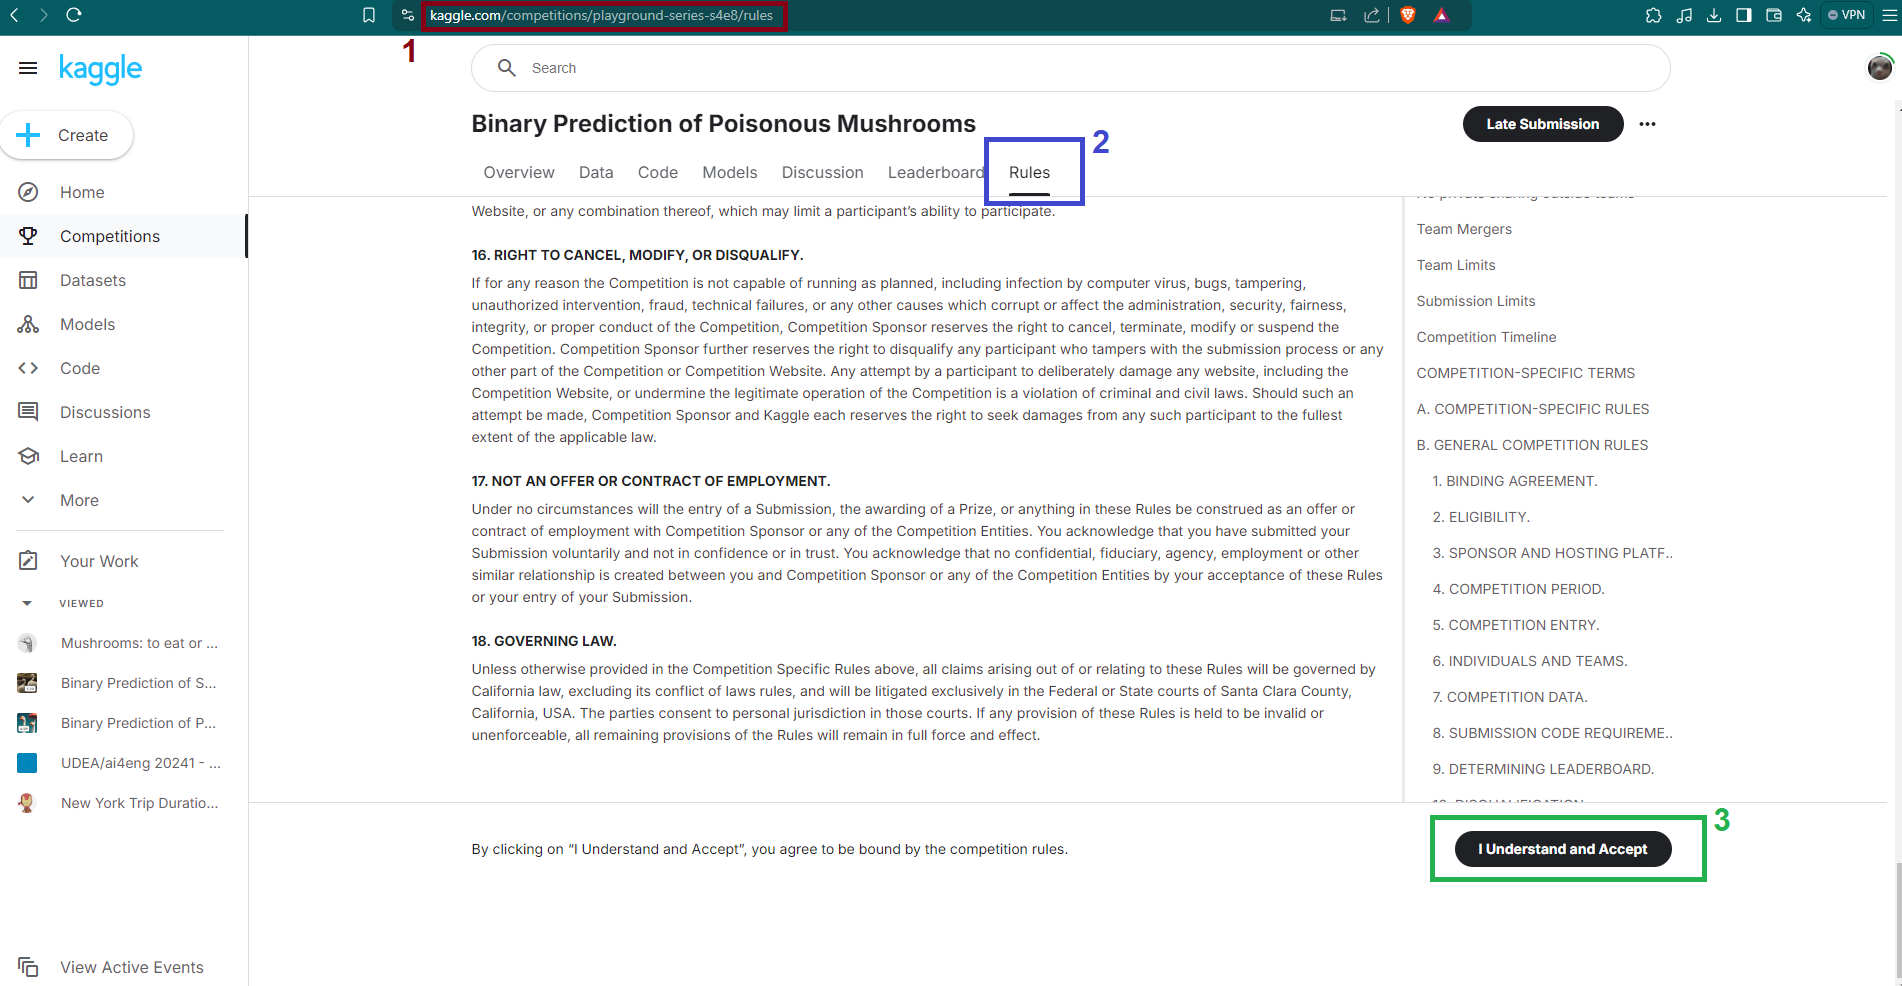















*   !mkdir -p ~/.kaggle: Crea un directorio llamado .kaggle en el directorio de inicio si aún no existe.

*   !cp kaggle.json ~/.kaggle/: Copia el archivo kaggle.json que contiene las credenciales de API en el directorio .kaggle.


*   !chmod 600 ~/.kaggle/kaggle.json: Cambia los permisos del archivo kaggle.json para garantizar que solo el propietario pueda leerlo y escribirlo.

*   !kaggle competitions download -c playground-series-s4e8: Descarga el conjunto de datos para la competencia "playground-series-s4e8" de Kaggle.

*   !unzip playground-series-s4e8.zip: Extrae el contenido del archivo ZIP descargado "playground-series-s4e8.zip".


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c playground-series-s4e8

!unzip playground-series-s4e8.zip


 69% 57.0M/82.3M [00:00<00:00, 171MB/s]
100% 82.3M/82.3M [00:00<00:00, 190MB/s]
Archive:  playground-series-s4e8.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


🟢 Leer los archivos y mostrar las primeras filas.

In [5]:
train = pd.read_csv(r"/content/train.csv")
test = pd.read_csv(r"/content/test.csv")
sample_submission = pd.read_csv(r"/content/sample_submission.csv", index_col = 'id')

print("train data :", train.shape)
print("test data :", test.shape)
print("sample_submission_data :", sample_submission.shape)

train data : (3116945, 22)
test data : (2077964, 21)
sample_submission_data : (2077964, 1)


In [6]:
train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


🟢 Creación de la matriz de correlación para ver qué tan dependientes son los datos.

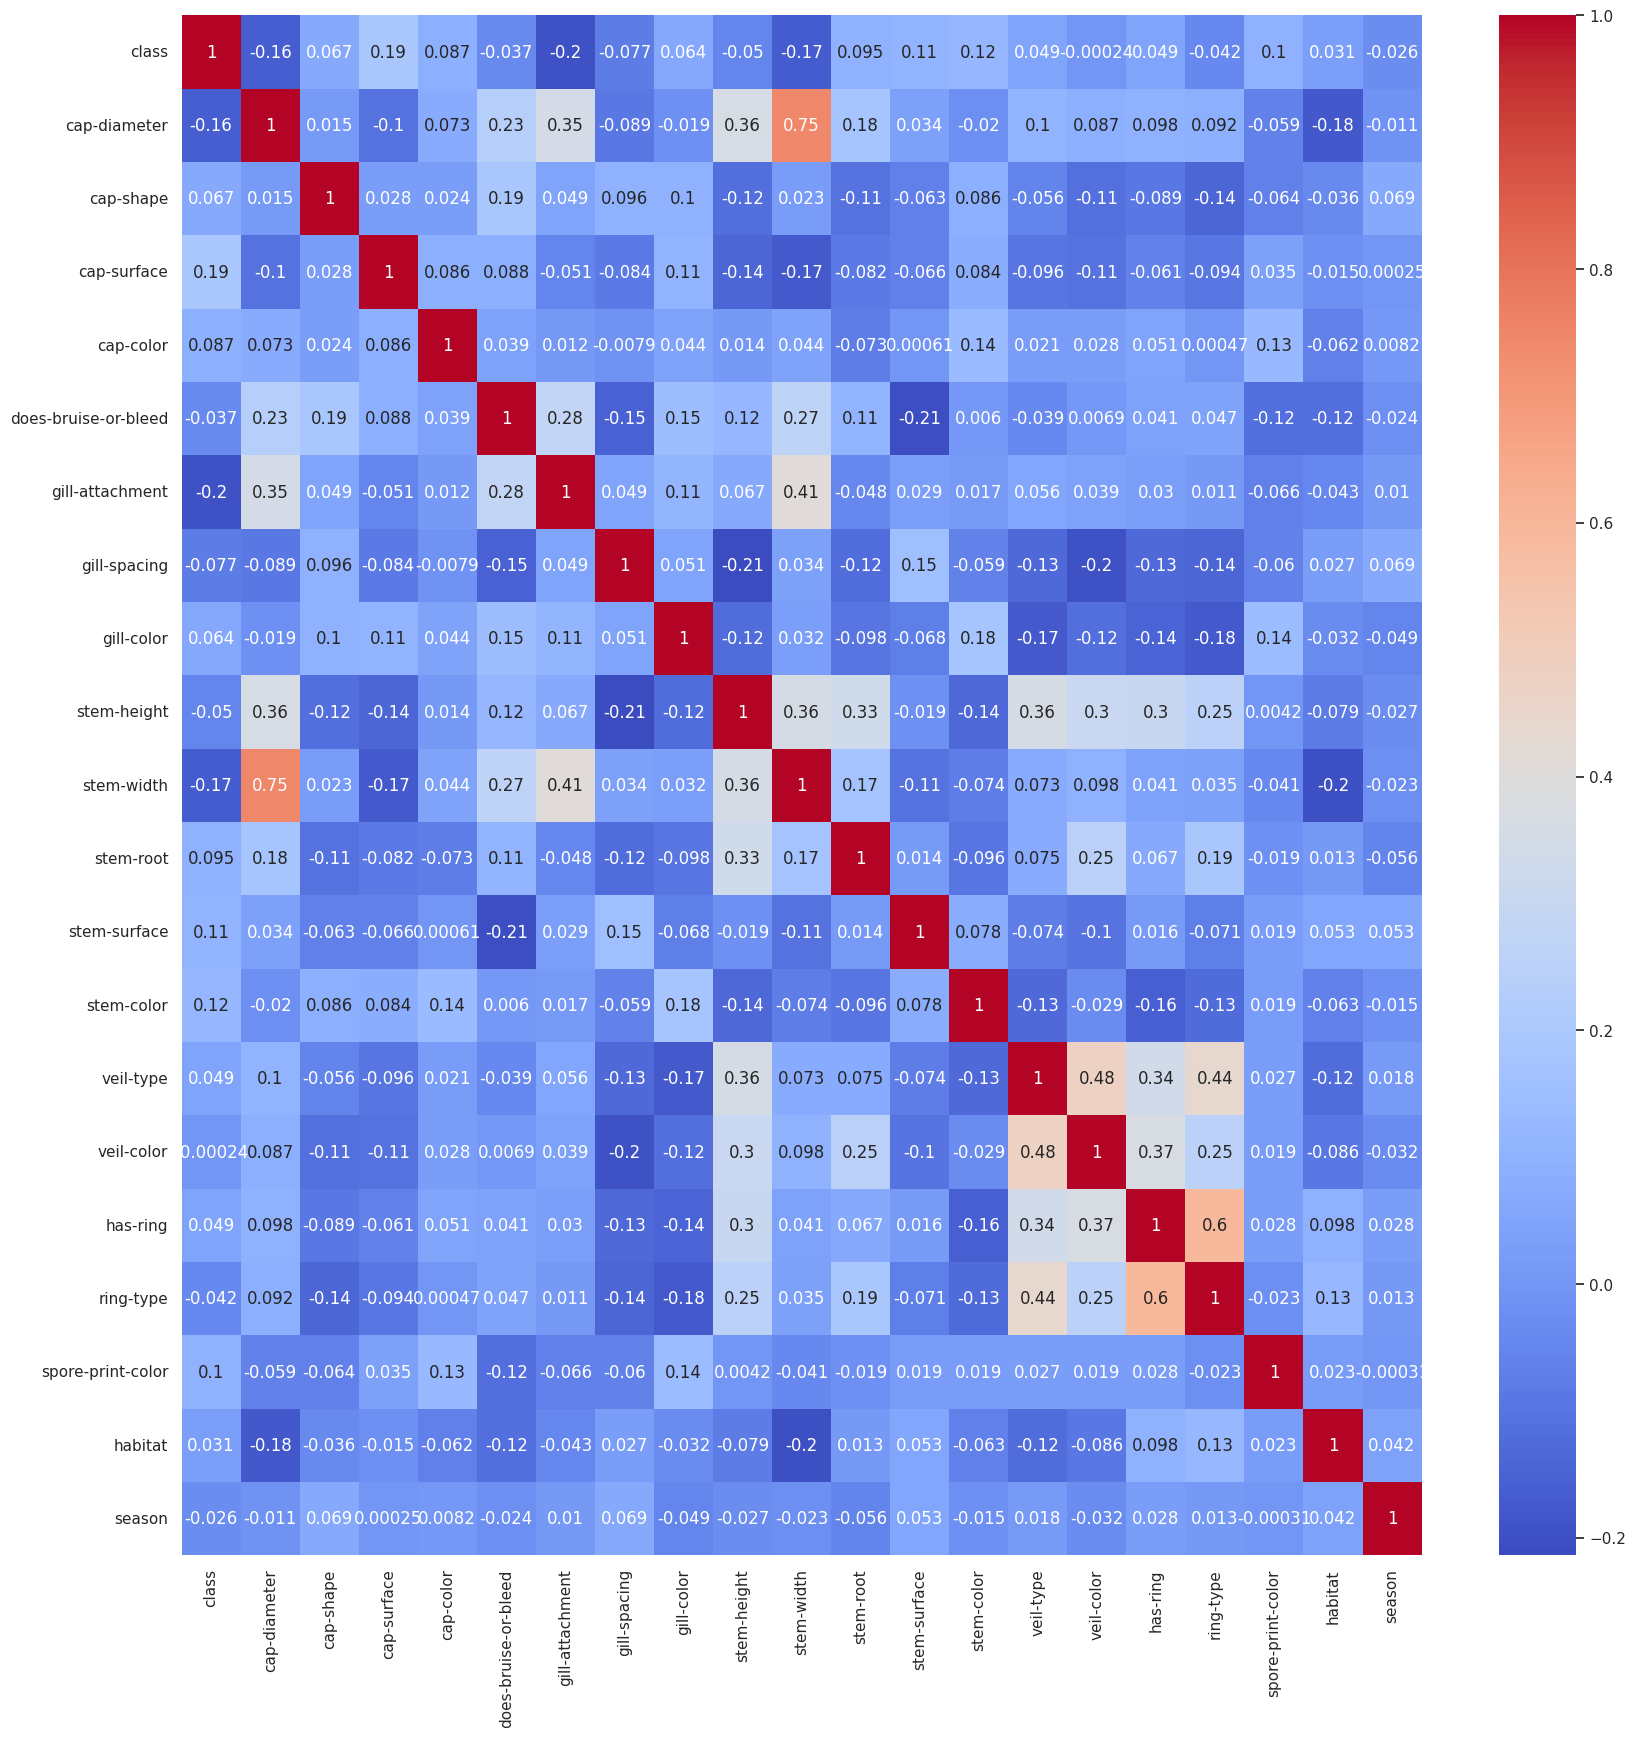

In [7]:
plt.figure(figsize=(20,20))
temp=train.dropna()
temp=train.drop('id',axis=1)
temp=temp.apply(lambda x : pd.factorize(x)[0] if x.dtype=='object'else x)
sns.heatmap(temp.corr(),annot=True,cmap='coolwarm')
plt.show()

<h1>⭐ Preprocesamiento ⭐<h1/>

🟢 Rellena los valores faltantes en la columna 'cap-diameter' del conjunto de datos de prueba con el valor más frecuente (moda).

In [8]:
test['cap-diameter'] =test['cap-diameter'] .fillna(test['cap-diameter'].mode()[0])
train['cap-diameter'] =train['cap-diameter'] .fillna(train['cap-diameter'].mode()[0])
test['stem-height'] =test['stem-height'] .fillna(test['stem-height'].mode()[0])

🟢 Procesar un DataFrame rellenando valores faltantes y estandarizando columnas categóricas.

In [9]:
def update(df):
    """
    Procesa un dataframe rellenando valores faltantes y estandarizando columnas categóricas.

    La función realiza las siguientes operaciones:
    1. Rellena los valores faltantes en las columnas categóricas con 'missing'.
    2. Reemplaza las categorías infrecuentes (aquellas con menos de 100 apariciones) con la etiqueta 'noise'.
    3. Convierte las columnas categóricas al tipo de dato 'category'.

    La función está diseñada para aplicarse a conjuntos de datos de entrenamiento y prueba con el fin de
    estandarizar sus datos categóricos.

    Parámetros:
    df (DataFrame): El dataframe a procesar.

    Retorna:
    DataFrame: El dataframe procesado con las columnas categóricas actualizadas.
    """

    threshold = 100

    cat_c = [
        'cap-shape','cap-surface','cap-color','does-bruise-or-bleed','gill-attachment','gill-spacing','gill-color',
        'stem-root','stem-surface','stem-color','veil-type','veil-color','has-ring','ring-type',
        'spore-print-color','habitat','season',
            ]

    for col in cat_c:
        df[col] = df[col].fillna('missing')
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < threshold, col] = "noise"
        df[col] = df[col].astype('category')

    return df

train  = update(train)
test   = update(test)

In [10]:
train['class'].value_counts()

,count
class,
p,1705396
e,1411549


🟢 Convierte la columna 'class' en un valor booleano y utiliza '*Target Encoding*' para transformar variables categóricas en numéricas, según su relación con la variable de destino.

In [11]:
train['class'] = train['class'] =='p'


encoder  = TargetEncoder()
cat_features = [val for val in train.drop(columns = 'class').select_dtypes(exclude ='number').columns]
for feature in cat_features:
    train[feature] = encoder.fit_transform(train[feature], train['class'])
    test[feature] = encoder.transform(test[feature])

In [12]:
train.tail()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
3116940,3116940,False,9.29,0.511944,0.513827,0.490915,0.506623,0.638971,0.570841,0.428440,...,0.351874,0.512659,0.417714,0.655582,0.503977,0.591104,0.421467,0.529055,0.528839,0.582461
3116941,3116941,False,10.88,0.549457,0.513827,0.497059,0.506623,0.571377,0.572446,0.590209,...,0.539927,0.512659,0.417714,0.541293,0.546672,0.533254,0.546738,0.529055,0.528839,0.582461
3116942,3116942,True,7.82,0.510166,0.478432,0.793249,0.555763,0.646344,0.570841,0.428440,...,0.539927,0.512659,0.693776,0.541293,0.503977,0.591104,0.996159,0.529055,0.528839,0.571586
3116943,3116943,False,9.45,0.459403,0.821915,0.490915,0.506623,0.348965,0.570841,0.590209,...,0.539927,0.700759,0.417714,0.541293,0.546672,0.591104,0.514140,0.529055,0.528839,0.582461
3116944,3116944,True,3.20,0.510166,0.369343,0.411920,0.555763,0.571377,0.572446,0.428440,...,0.539927,0.512659,0.417714,0.541293,0.546672,0.533254,0.546738,0.529055,0.674602,0.582461


🟢 Crear un DataFrame **X** con todas las columnas excepto 'class', y crear una serie **y** con los valores de la columna 'class'.

In [13]:
X = train.drop(['class'], axis=1)
y = train['class']

<h1>⭐ Dividir los datos en conjuntos de entrenamiento y validación ⭐<h1/>


In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=5)

<h1>⭐ Entrenar el modelo utilizando XGBoost ⭐<h1/>


🟢 Este código inicializa un XGBClassifier con hiperparámetros específicos, incluida la profundidad máxima, la tasa de aprendizaje y los términos de regularización. El clasificador se entrena en el conjunto de datos de entrenamiento (X_train, y_train), mientras monitorea el rendimiento en un conjunto de validación (X_val, y_val) utilizando la métrica de pérdida de registros. Se emplea la parada anticipada para detener el entrenamiento si no se observa ninguna mejora en 10 rondas, y el progreso se imprime en la consola.


⛔ **¡Este procedimiento puede tardar algunos minutos!**

In [15]:


clf = xgb.XGBClassifier(
    max_depth=8,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    learning_rate=0.1,
    n_estimators=2000,    # Comenzar con un número grande y utilizar la parada temprana
    random_state=5,
    eval_metric="logloss",      # Métrica a evaluar
    early_stopping_rounds=10,   # Detener si no hay mejora en 10 rondas
)

preds = clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Datos de validación para monitorear
    verbose=True               # Mostrar progreso
)

[0]	validation_0-logloss:0.63464
[1]	validation_0-logloss:0.58300
[2]	validation_0-logloss:0.53535
[3]	validation_0-logloss:0.48788
[4]	validation_0-logloss:0.44967
[5]	validation_0-logloss:0.41808
[6]	validation_0-logloss:0.38934
[7]	validation_0-logloss:0.36370
[8]	validation_0-logloss:0.33759
[9]	validation_0-logloss:0.31293
[10]	validation_0-logloss:0.29229
[11]	validation_0-logloss:0.27637
[12]	validation_0-logloss:0.25791
[13]	validation_0-logloss:0.24360
[14]	validation_0-logloss:0.23352
[15]	validation_0-logloss:0.22305
[16]	validation_0-logloss:0.21417
[17]	validation_0-logloss:0.20817
[18]	validation_0-logloss:0.19992
[19]	validation_0-logloss:0.19279
[20]	validation_0-logloss:0.18431
[21]	validation_0-logloss:0.17402
[22]	validation_0-logloss:0.16962
[23]	validation_0-logloss:0.16205
[24]	validation_0-logloss:0.15366
[25]	validation_0-logloss:0.14713
[26]	validation_0-logloss:0.14229
[27]	validation_0-logloss:0.13771
[28]	validation_0-logloss:0.13197
[29]	validation_0-loglos

<h1>⭐ Predicciones ⭐<h1/>

🟢 Generar las predicciones y el archivo solución para subir a Kaggle.

In [16]:
preds = clf.predict(test)
sample_submission['class'] = preds
sample_submission['class'] = sample_submission['class'].replace({1: 'p', 0: 'e'})
sample_submission.to_csv('submission.csv')